## Exploratory data analysis: PCA and Mahalanobis distance analysis
**Author:** Y.X. Wu

This notebook aims to conduct a comparative analysis between our new data set and existing literature data set based on two properties: hardness and corrosion. Both data sets have a defined compositional feature space. The new data set, however, is generated in a different regime of the compositional feature space.

The purpose of the analysis is twofold:

* **Principal Component Analysis (PCA)**: We'll use PCA as a technique to reduce the dimensionality of the feature space. It will allow us to effectively visualize the new data alongside the literature data within the same reduced feature space. PCA does this by transforming the original variables into a new set of uncorrelated variables called principal components, which are ordered by the amount of variance they can explain from the original data. This allows us to capture most of the information in the original data with fewer dimensions.

* **Mahalanobis Distance Calculation**: Following the visualization, we'll take a more in-depth look into the data by calculating the Mahalanobis distance for all the new data points from the centroid of the literature data set. The Mahalanobis distance is a measure of the distance between a point and a distribution, not between two distinct points. It's effectively a multivariate equivalent of the Euclidean distance. However, unlike Euclidean distance, the Mahalanobis distance is scale-invariant and takes into account the correlations of the data set. By calculating the Mahalanobis distance, we can quantify how much the new data deviates from the distribution of the literature data.

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import math 
import matplotlib.cm as cm
import matplotlib as mpl
import os

# display the current working directory
display("Current working directory: {0}".format(os.getcwd()))

data_path = '../Dataset_Cleaned/'
display(os.path.isfile(data_path+'Hardness_database_YW_v3.xlsx'))

'Current working directory: /nethome/yuxiang.wu/CCA-representation-ML/Dataset_EDA_Pairplot_PCA_Mahalanobis'

True

### Import hardness and corrosion LITERATURE datasets 

In [36]:
# Define column names for the composition dataframe
column_compo_H = ['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn', 'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf']
column_compo_C = ['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn', 'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y']

# Import the Hardness dataset, starting from the third row (header=2) because the first two rows are presumably not relevant
df_H = pd.read_excel(data_path + 'Hardness_database_YW_v3.xlsx', header=2)

# Extract relevant columns from the Hardness dataframe, and fill in any missing values with zero
df_H_compo = df_H[column_compo_H].fillna(0)
 
# Import the Corrosion dataset, starting from the third row (header=2) because the first two rows are presumably not relevant
df_C = pd.read_excel(data_path + 'Corrosion_database_YW_v3.xlsx', header=2)

# Extract relevant columns from the Corrosion dataframe, and fill in any missing values with zero
df_C_compo = df_C[column_compo_C].fillna(0)

# Display the first row of both dataframes
display(df_H_compo.head(1), df_H_compo.shape,
        df_C_compo.head(1), df_C_compo.shape)  

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y,Zr,Hf
0,19.92,18.54,20.93,0.0,0.0,0,0.0,0.0,0.0,19.59,0.0,0.0,0.0,0.0,0.0,21.02,0,0.0,0.0,0.0


(680, 20)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y
0,69.77,18.0,10.0,0.0,0.0,0.0,0.0,0.03,1.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(712, 18)

### Import NEW dataset

In [3]:
# Define relevant columns for each dataframe
columns_FeCrNiMoTi = ['Fe', 'Cr', 'Ni', 'Mo', 'Ti']
columns_FeCrNiCoV  = ['Fe', 'Cr', 'Ni', 'Co', 'V']

# Import each dataset, select relevant columns, and fill NaN values with zero
df_compo_new_FeCrNiMoTi = pd.read_excel(data_path + 'MultiTaskModel_NiCrMoTiFe_KW131_wt_pct.xlsx')[columns_FeCrNiMoTi].fillna(0)
df_compo_new_FeCrNiCoV  = pd.read_excel(data_path + 'MultiTaskModel_NiCrCoVFe_KW99_wt_pct.xlsx')[columns_FeCrNiCoV].fillna(0)

# Display the first row of both dataframes
display(df_compo_new_FeCrNiMoTi.head(1))
display(df_compo_new_FeCrNiCoV.head(1))


,Fe,Cr,Ni,Mo,Ti
0,14.316994,35.210247,45.453038,4.138939,0.880782


,Fe,Cr,Ni,Co,V
0,10.271486,31.290494,51.985556,4.851446,1.601018


### Datasets labelling for both datasets and concatenation

In [4]:
# Assign 'dataset' values in Corrosion and Hardness dataframes
for df, label in zip([df_C_compo, df_H_compo, df_compo_new_FeCrNiMoTi, df_compo_new_FeCrNiCoV], 
                     ['corrosion dataset', 'hardness dataset', 'new FeCrNiMoTi', 'new FeCrNiCoV']):
    df['dataset'] = label

# Concatenate dataframes, export to Excel, and display results
df_conc = pd.concat([df_C_compo, df_H_compo], ignore_index=True).fillna(0)
df_conc.to_excel('pairplot_corrosion_hardness_datasets.xlsx')
display(df_conc.iloc[[0, 1, -2, -1]], df_conc.shape)
 

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Al,V,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf
0,69.77,18.00,10.00,0.00,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,corrosion dataset,0.0,0.0
1,69.77,18.00,10.00,0.00,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,corrosion dataset,0.0,0.0
1390,21.72,20.23,22.83,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,10.5,0.0,0.0,0.0,0.00,0.0,0.0,hardness dataset,0.0,0.0
1391,20.17,0.00,42.40,6.93,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,9.2,0.0,0.0,21.29,0.0,0.0,hardness dataset,0.0,0.0


(1392, 21)

In [5]:
# Function to process and concatenate DataFrame details
def process_df(df, dataset_name, df_conc):
    return pd.concat([df_conc, df.assign(dataset=dataset_name)], ignore_index=True).fillna(0)

# Concatenate and preprocess data
df_conc_new_FeCrNiMoTi = process_df(df_compo_new_FeCrNiMoTi, 'new FeCrNiMoTi', df_conc)
df_conc_new_FeCrNiCoV = process_df(df_compo_new_FeCrNiCoV, 'new FeCrNiCoV', df_conc)

# Concatenate both new datasets and remove duplicates
df_conc_new = pd.concat([df_conc, 
                         df_compo_new_FeCrNiMoTi,
                         df_compo_new_FeCrNiCoV], 
                         ignore_index=True).fillna(0)

display(df_conc_new.shape)

# Display the desired data
for df in [df_conc_new_FeCrNiMoTi, df_conc_new_FeCrNiCoV]:
    display(df.iloc[[0, -71, -2, -1]], df.shape)


(1530, 21)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Al,V,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf
0,69.770000,18.000000,10.000000,0.000000,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,corrosion dataset,0.0,0.0
1390,21.720000,20.230000,22.830000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,...,10.5,0.0,0.0,0.000000,0.0,0.0,0.0,hardness dataset,0.0,0.0
1459,65.324524,4.818151,24.401985,2.839441,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,2.615900,0.0,0.0,0.0,new FeCrNiMoTi,0.0,0.0
1460,63.370312,5.076982,23.439965,4.034033,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,4.078709,0.0,0.0,0.0,new FeCrNiMoTi,0.0,0.0


(1461, 21)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Al,V,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf
0,69.770000,18.000000,10.000000,0.0,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,corrosion dataset,0.0,0.0
1390,21.720000,20.230000,22.830000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,10.5,0.000000,0.0,0.0,0.000000,0.0,0.0,hardness dataset,0.0,0.0
1459,54.187698,5.396440,32.543752,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,5.431837,0.0,0.0,2.440272,0.0,0.0,new FeCrNiCoV,0.0,0.0
1460,51.347188,5.827793,31.584854,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,8.142295,0.0,0.0,3.097870,0.0,0.0,new FeCrNiCoV,0.0,0.0


(1461, 21)

### Pairplots: the new datasets in relation to hardness and corrosion literatrue datasets

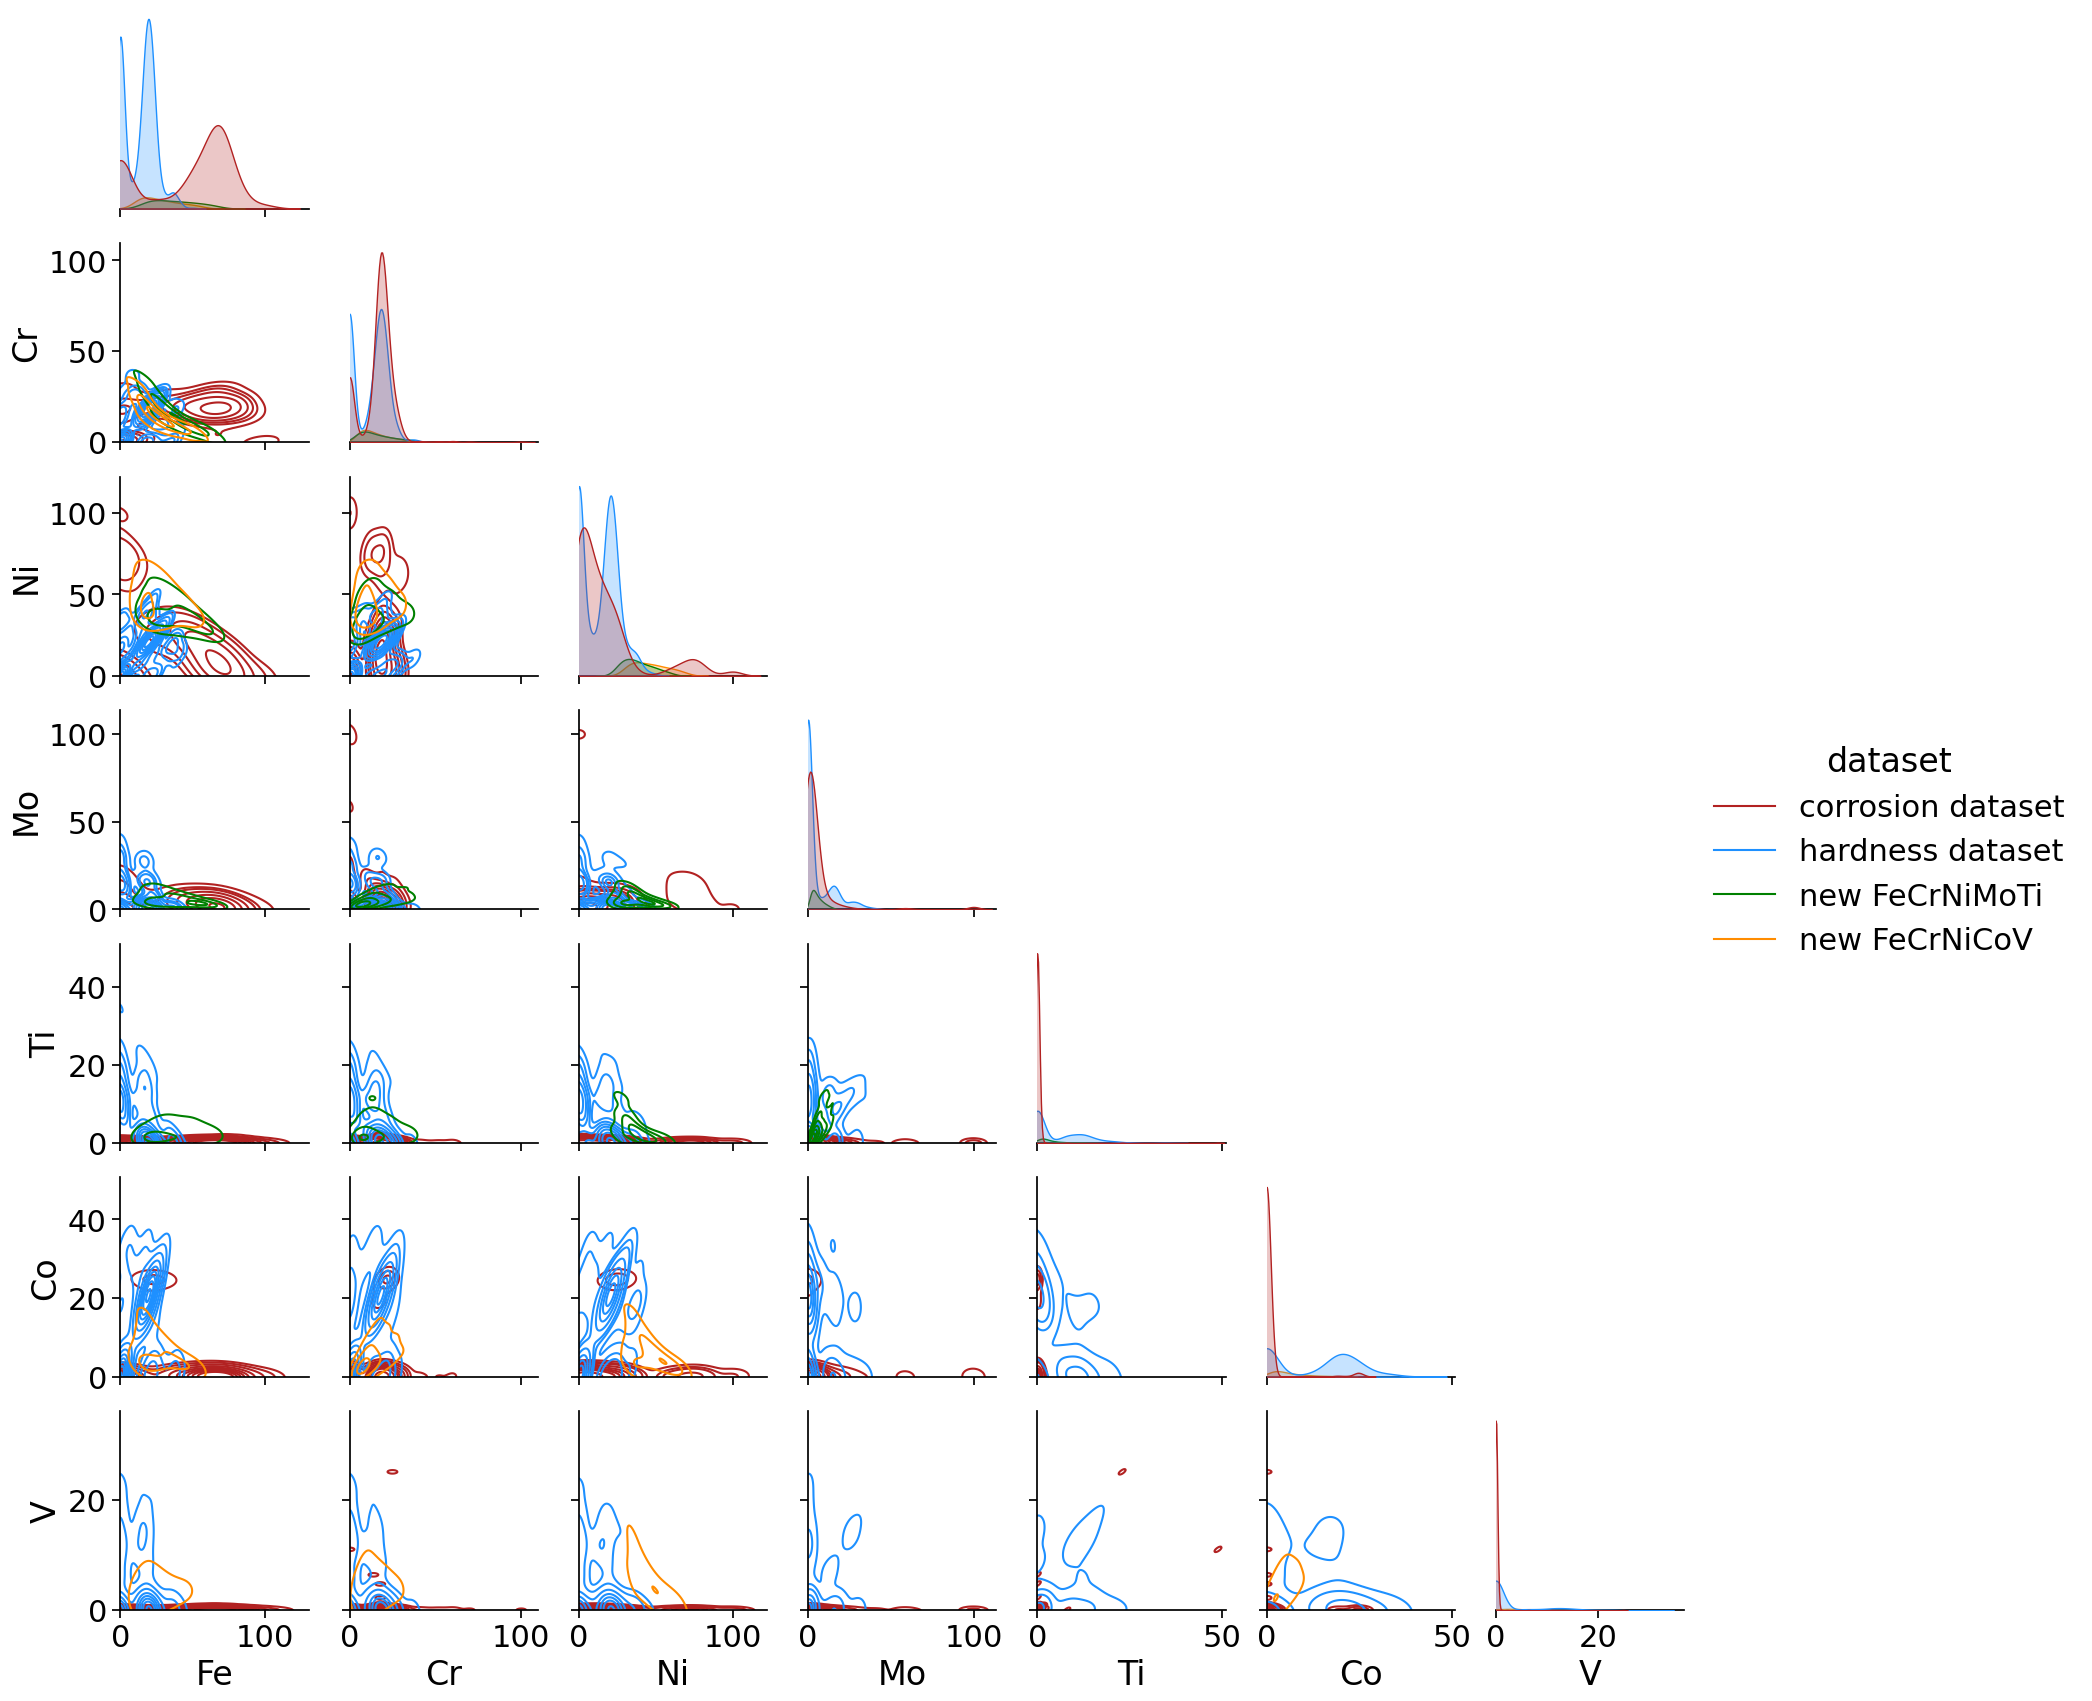

In [6]:
sns.set_context("notebook", font_scale=2)

# Define color palette for the pairplot
palette = ["firebrick", "dodgerblue", "green", "darkorange"]

# Create pairplot with KDE for all data
grid_kde = sns.pairplot(df_conc_new, vars=['Fe', 'Cr', 'Ni', 'Mo', 'Ti', 'Co', 'V'], 
                        hue="dataset", kind="kde", corner=True, palette=palette)

# Adjust x and y limits using list comprehension
_ = [[ax.set_xlim(left=0), ax.set_ylim(bottom=0)] for ax_row in grid_kde.axes for ax in ax_row if ax is not None]

plt.savefig('pairplot_literature+new.png', bbox_inches='tight')

# Show the plots
plt.show()


## 1. Let's try PCA (Principal Component Analysis) 
https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf,PCA1,PCA2
0,69.77,18.0,10.0,0.0,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,40.544503,-9.952558


Explained variance ratio (first two components): [0.39299539 0.21353582]


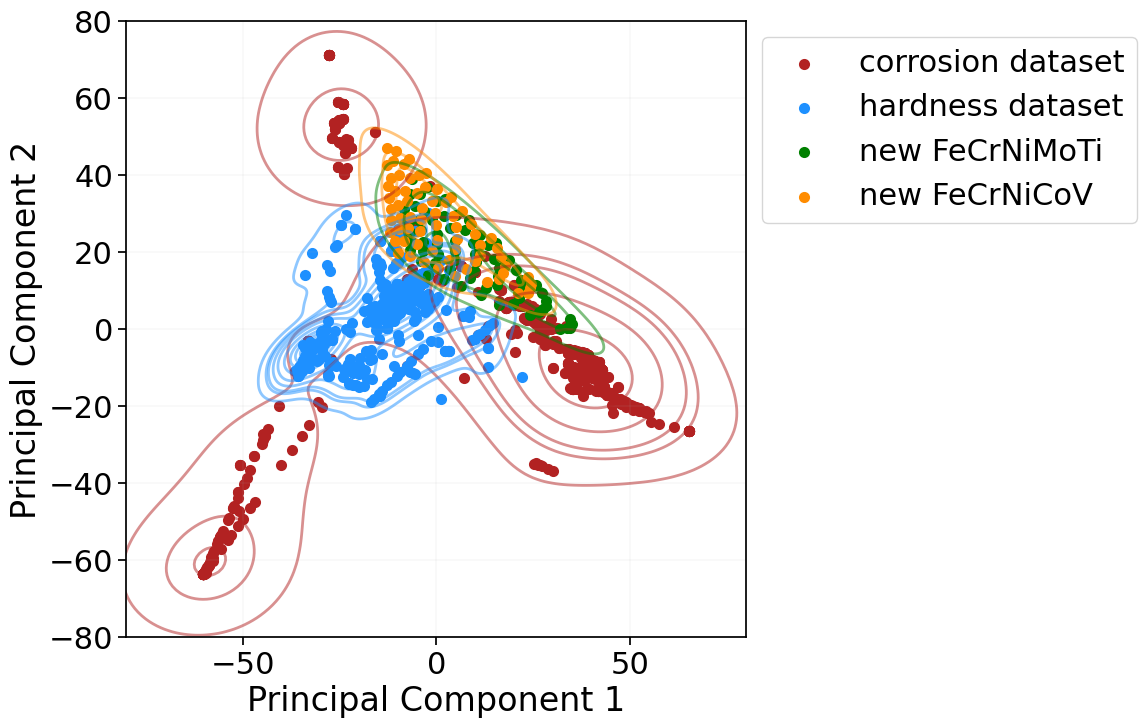

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Prepare the dataset for PCA
df_conc_new_pca = df_conc_new.copy()

# Map the "dataset" column to numerical values
dataset_mapping = {"corrosion dataset": 0, "hardness dataset": 1, "new FeCrNiMoTi": 2, "new FeCrNiCoV": 3}
df_conc_new_pca["dataset"] = df_conc_new_pca["dataset"].map(dataset_mapping)

# Partition the data
X_conc = df_conc_new_pca.drop(columns='dataset').values  # Feature matrix
y_conc = df_conc_new_pca['dataset'].values  # Target array

# 2D PCA
pca = PCA(n_components=2)
X_conc_r = pca.fit_transform(X_conc)

# add the PCA components to the dataframe df_conc_new_pca
df_conc_new_pca['PCA1'] = X_conc_r[:, 0]
df_conc_new_pca['PCA2'] = X_conc_r[:, 1]

display(df_conc_new_pca.head(1))

# Print explained variance ratio
print(f"Explained variance ratio (first two components): {pca.explained_variance_ratio_}")

# plot the projection of PCA analysis
plt.figure(figsize=(8, 8))
colors = ["firebrick", "dodgerblue", "green", "darkorange"]
dataset_names = ["corrosion dataset", "hardness dataset", "new FeCrNiMoTi", "new FeCrNiCoV"]

for color, i, dataset_name in zip(colors, range(len(dataset_names)), dataset_names):
    plt.scatter(X_conc_r[y_conc == i, 0], X_conc_r[y_conc == i, 1], color=color, alpha=1, lw=2, label=dataset_name)

sns.kdeplot(data=df_conc_new_pca, x="PCA1", y="PCA2", hue='dataset', 
            palette=colors, levels=10, linewidths=2, alpha=0.5, thresh=0.02)

plt.grid(linewidth=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlim(-80, 80)
plt.ylim(-80, 80)
plt.legend(loc="upper left", bbox_to_anchor=(1,1), scatterpoints=1)

plt.savefig('PCA 2D_literature+new.png', bbox_inches='tight')
plt.show()


## 2. Let's try to use the concept of outlier/novelty detection - using Mahalanobis distance

### Approach Multivariate Outliers and Mahalanobis Distance (simple approach)
https://www.geeksforgeeks.org/how-to-calculate-mahalanobis-distance-in-python/
https://www.machinelearningplus.com/statistics/mahalanobis-distance/ 
https://scikit-learn.org/stable/modules/outlier_detection.html


In [8]:
import scipy.stats as stats
from scipy.stats import chi2
import numpy as np

In [9]:
df_C_pca = df_conc_new_pca[df_conc_new_pca['dataset'] == 0]
df_H_pca = df_conc_new_pca[df_conc_new_pca['dataset'] == 1]
df_new_FeCrNiMoTi_pca = df_conc_new_pca[df_conc_new_pca['dataset'] == 2]
df_new_FeCrNiCoV_pca = df_conc_new_pca[df_conc_new_pca['dataset'] == 3]


# prepare the df for calculating Mahalanobis distance (cannot have string in df)
display(df_C_pca.iloc[[0, -1]], df_C_pca.shape, 
        df_H_pca.iloc[[0, -1]], df_H_pca.shape, 
        df_new_FeCrNiMoTi_pca.iloc[[0, -1]], df_new_FeCrNiMoTi_pca.shape,
        df_new_FeCrNiCoV_pca.iloc[[0, -1]], df_new_FeCrNiCoV_pca.shape)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf,PCA1,PCA2
0,69.77,18.00,10.0,0.0,0.0,0.0,0.0,0.03,1.00,1.00,...,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,40.544503,-9.952558
711,0.16,0.23,0.0,0.0,0.0,0.0,0.0,0.00,0.08,0.02,...,0.0,0.0,0.0,2.43,0.0,0,0.0,0.0,-58.871892,-61.840695


(712, 23)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf,PCA1,PCA2
712,19.92,18.54,20.93,0.00,0.0,0.0,0.0,0.0,0.0,19.59,...,0.0,0.0,21.02,0.0,0.0,1,0.0,0.0,-5.402516,12.239616
1391,20.17,0.00,42.40,6.93,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,21.29,0.0,0.0,1,0.0,0.0,-9.865660,26.057831


(680, 23)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf,PCA1,PCA2
1392,14.316994,35.210247,45.453038,4.138939,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.880782,0.0,0.0,0.0,2,0.0,0.0,-8.226433,31.248550
1460,63.370312,5.076982,23.439965,4.034033,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.078709,0.0,0.0,0.0,2,0.0,0.0,31.837815,0.103357


(69, 23)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf,PCA1,PCA2
1461,10.271486,31.290494,51.985556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.851446,0.0,0.0,3,0.0,0.0,-12.580944,37.136561
1529,51.347188,5.827793,31.584854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.097870,0.0,0.0,3,0.0,0.0,21.118125,9.488586


(69, 23)

### preparing the existing datasets (literature+new)

In [10]:
# Merge existing and new datasets, replacing missing values with 0
df_C_new_FeCrNiMoTi = pd.concat([df_C_pca, df_new_FeCrNiMoTi_pca], ignore_index=True).fillna(0)
df_C_new_FeCrNiCoV = pd.concat([df_C_pca, df_new_FeCrNiCoV_pca], ignore_index=True).fillna(0)
df_H_new_FeCrNiMoTi = pd.concat([df_H_pca, df_new_FeCrNiMoTi_pca], ignore_index=True).fillna(0)
df_H_new_FeCrNiCoV = pd.concat([df_H_pca, df_new_FeCrNiCoV_pca], ignore_index=True).fillna(0)

def process_df_Mahal(df): 
    df_num = df.loc[:, ~df.columns.isin(['dataset', 'PCA1', 'PCA2'])]
    df_label = df[['dataset', 'PCA1', 'PCA2']]

    # Detect zero columns using 'all' method after comparing with 0
    zero_columns = (df_num == 0).all()

    # Print the names of the columns containing only zeros with context
    print("Columns only containing zeros:", zero_columns[zero_columns].index.tolist())

    # Drop the zero columns using boolean indexing 
    df_num = df_num.loc[:, ~zero_columns]

    return df_num, df_label

# Process each dataframe and separate numerical and label data
df_C_new_FeCrNiMoTi_num, df_C_new_FeCrNiMoTi_label = process_df_Mahal(df_C_new_FeCrNiMoTi)
df_C_new_FeCrNiCoV_num, df_C_new_FeCrNiCoV_label = process_df_Mahal(df_C_new_FeCrNiCoV)
df_H_new_FeCrNiMoTi_num, df_H_new_FeCrNiMoTi_label = process_df_Mahal(df_H_new_FeCrNiMoTi)
df_H_new_FeCrNiCoV_num, df_H_new_FeCrNiCoV_label = process_df_Mahal(df_H_new_FeCrNiCoV)
  
display(df_C_new_FeCrNiMoTi_num.iloc[[0,-1]], df_C_new_FeCrNiMoTi_label.iloc[[0,-1]])
 

Columns only containing zeros: ['Zr', 'Hf']
Columns only containing zeros: ['Zr', 'Hf']
Columns only containing zeros: ['N', 'Mg']
Columns only containing zeros: ['N', 'Mg']


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y
0,69.770000,18.000000,10.000000,0.000000,0.0,0.0,0.0,0.03,1.0,1.0,0.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
780,63.370312,5.076982,23.439965,4.034033,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,4.078709,0.0,0.0,0.0


,dataset,PCA1,PCA2
0,0,40.544503,-9.952558
780,2,31.837815,0.103357


### calculate the Mahalanobis distance

In [11]:
df_C_new_FeCrNiMoTi_Mahl = df_C_new_FeCrNiMoTi_num.copy()
df_C_new_FeCrNiCoV_Mahl = df_C_new_FeCrNiCoV_num.copy()
df_H_new_FeCrNiMoTi_Mahl = df_H_new_FeCrNiMoTi_num.copy()
df_H_new_FeCrNiCoV_Mahl = df_H_new_FeCrNiCoV_num.copy()

# Function to calculate the Mahalanobis distance of each point to the "center" of the dataset 
def calculateMahalanobis(y=None, data=None, cov=None):
    # Compute the Mahalanobis Distance between each row of y and the data  
    # y    : matrix of data with, say, p columns (new observation).
    # data : ndarray of the distribution (existing data), from which Mahalanobis distance of each observation of y is to be computed.
    # cov  : covariance matrix (p x p) of the distribution(existing data). If None, will be computed from data.
   
    y_mu = y - np.mean(data, axis=0)
    if cov is None:
        cov = np.cov(data.values.T)
        cov += np.eye(cov.shape[0]) * 1e-6
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(y_mu, inv_covmat)
    mahal = np.dot(left, y_mu.T)

    # print(y_mu.isna().sum().sum())  # check if y_mu has any NaN
    # print(inv_covmat)  # see the inverse covariance matrix
    return mahal.diagonal()

# y: new observation, data: existing data from which Mahalanobis distance is to be computed.
df_C_new_FeCrNiMoTi_Mahl['Mahalanobis'] = calculateMahalanobis(y = df_C_new_FeCrNiMoTi_Mahl, data= df_C_new_FeCrNiMoTi_num)
df_C_new_FeCrNiCoV_Mahl['Mahalanobis'] = calculateMahalanobis(y = df_C_new_FeCrNiCoV_Mahl, data= df_C_new_FeCrNiCoV_num)
df_H_new_FeCrNiMoTi_Mahl['Mahalanobis'] = calculateMahalanobis(y = df_H_new_FeCrNiMoTi_Mahl, data= df_H_new_FeCrNiMoTi_num)
df_H_new_FeCrNiCoV_Mahl['Mahalanobis'] = calculateMahalanobis(y = df_H_new_FeCrNiCoV_Mahl, data= df_H_new_FeCrNiCoV_num)

display(df_C_new_FeCrNiMoTi_Mahl.head(1))
display(df_C_new_FeCrNiCoV_Mahl.head(1))
display(df_H_new_FeCrNiMoTi_Mahl.head(1))
display(df_H_new_FeCrNiCoV_Mahl.head(1))


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y,Mahalanobis
0,69.77,18.0,10.0,0.0,0.0,0.0,0.0,0.03,1.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.565848


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y,Mahalanobis
0,69.77,18.0,10.0,0.0,0.0,0.0,0.0,0.03,1.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.400106


,Fe,Cr,Ni,Mo,W,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Y,Zr,Hf,Mahalanobis
0,19.92,18.54,20.93,0.0,0.0,0.0,0.0,0.0,19.59,0.0,0.0,0.0,0.0,0.0,21.02,0.0,0.0,0.0,7.810072


,Fe,Cr,Ni,Mo,W,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Y,Zr,Hf,Mahalanobis
0,19.92,18.54,20.93,0.0,0.0,0.0,0.0,0.0,19.59,0.0,0.0,0.0,0.0,0.0,21.02,0.0,0.0,0.0,7.933566


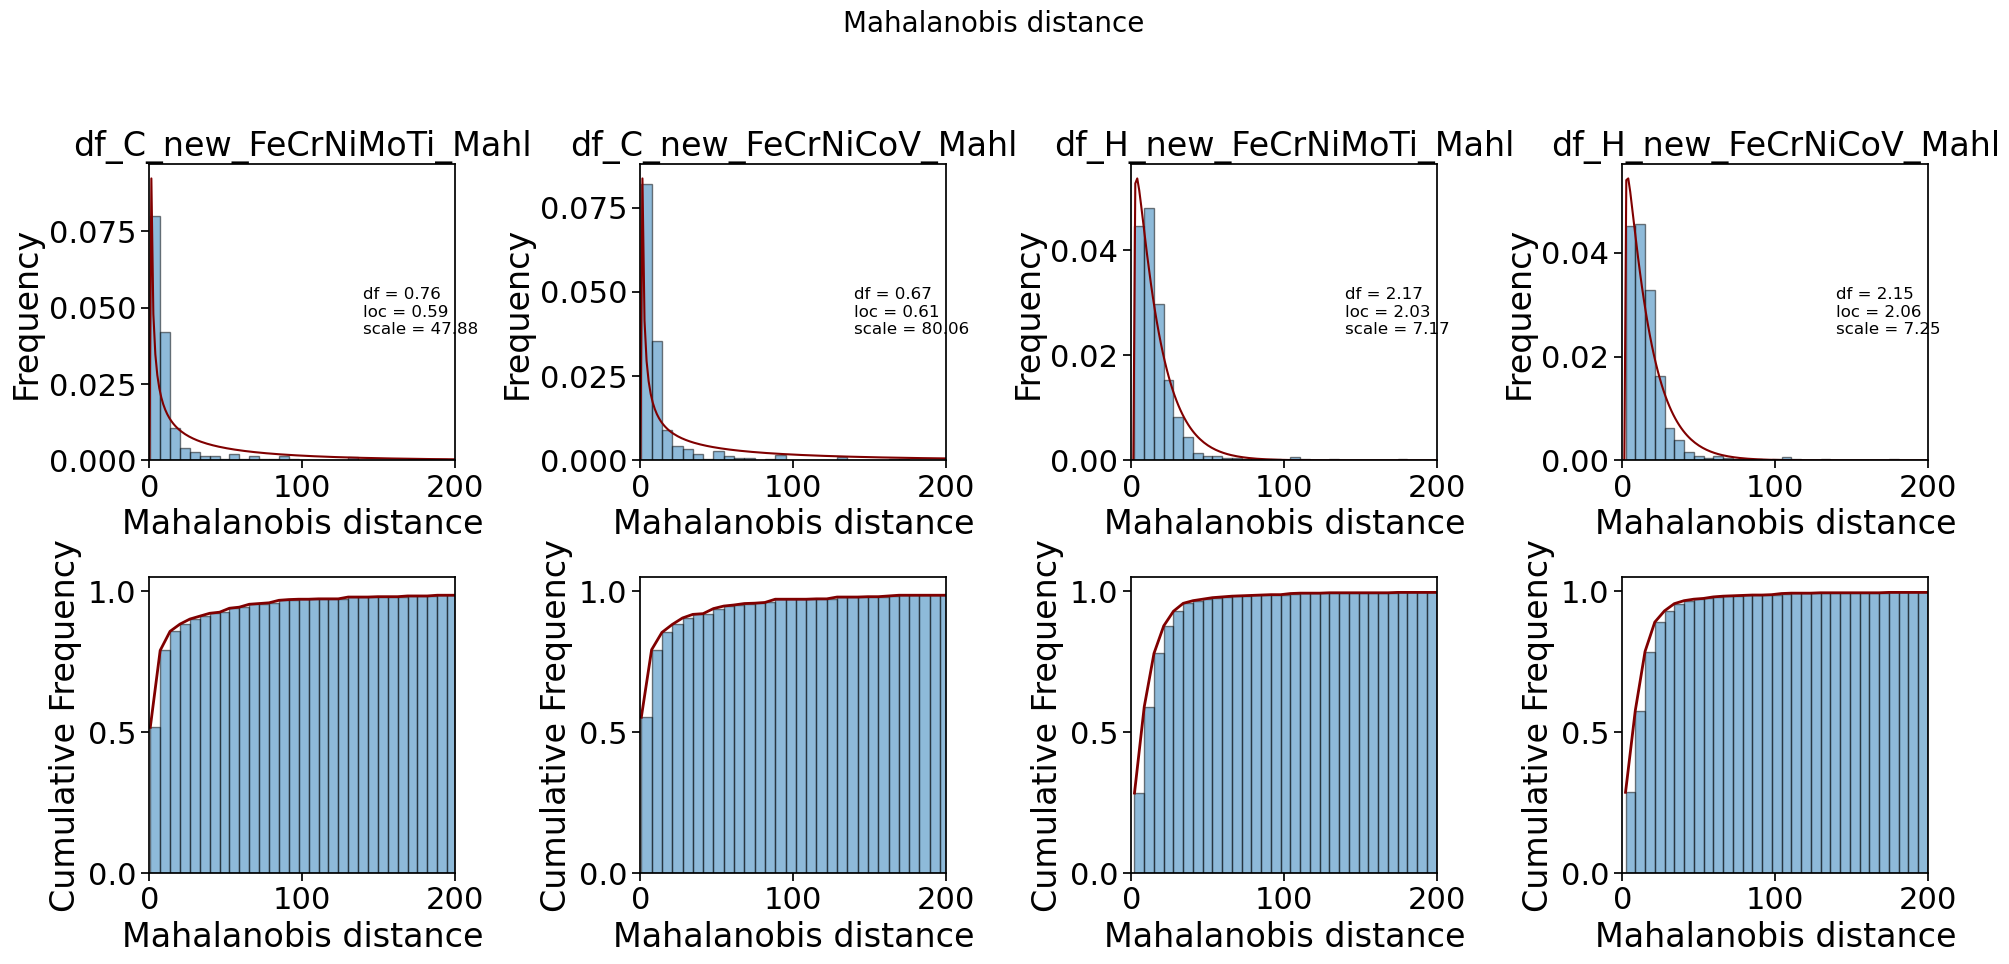

In [12]:
# Define dataframes in a list
dfs = [df_C_new_FeCrNiMoTi_Mahl, df_C_new_FeCrNiCoV_Mahl, df_H_new_FeCrNiMoTi_Mahl, df_H_new_FeCrNiCoV_Mahl]
titles = ['df_C_new_FeCrNiMoTi_Mahl', 'df_C_new_FeCrNiCoV_Mahl', 'df_H_new_FeCrNiMoTi_Mahl', 'df_H_new_FeCrNiCoV_Mahl']

# Set up subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Mahalanobis distance', fontsize=20)

# Iterate through dataframes
for i, df in enumerate(dfs):
    # Plot histogram
    axs[0,i].hist(df['Mahalanobis'], bins=100, edgecolor='black', alpha=0.5, density=True)
    axs[0,i].set_xlabel('Mahalanobis distance')
    axs[0,i].set_ylabel('Frequency')
    axs[0,i].set_xlim(0, 200)
    axs[0,i].set_title(titles[i])

    # Fit a chi-squared distribution to the data
    df_param, loc, scale = stats.chi2.fit(df['Mahalanobis'])
    # Plot the fitted distribution over the histogram
    x_chi2 = np.linspace(0, np.amax(df['Mahalanobis']), 500)
    pdf_chi2 = stats.chi2.pdf(x_chi2, df=df_param, loc=loc, scale=scale)
    axs[0,i].plot(x_chi2, pdf_chi2, 'maroon')
    # Add the fitted values to the plot
    axs[0,i].text(0.7, 0.5, f"df = {df_param:.2f}\nloc = {loc:.2f}\nscale = {scale:.2f}",
                  transform=axs[0,i].transAxes, ha='left', va='center', fontsize=12)

    # Plot CDF
    counts, bins, patches = axs[1,i].hist(df['Mahalanobis'], bins=100, edgecolor='black', alpha=0.5, cumulative=True, density=True)
    axs[1,i].plot(bins[:-1], counts, 'maroon', lw=2)
    axs[1,i].set_xlim(0, 200)
    axs[1,i].set_xlabel('Mahalanobis distance')
    axs[1,i].set_ylabel('Cumulative Frequency')

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to prevent overlapping
plt.show()


### 3. Let's use chi2 statistics to get a more presentable number: p-value based on chi2 distribution with degree of freedom = 2
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4381501/

In [13]:
# calculate p-value for each mahalanobis distance using 
df_C_new_FeCrNiMoTi_Mahl['p value'] = 1 - chi2.cdf(df_C_new_FeCrNiMoTi_Mahl['Mahalanobis'], 2)
df_C_new_FeCrNiCoV_Mahl['p value'] = 1 - chi2.cdf(df_C_new_FeCrNiCoV_Mahl['Mahalanobis'], 2)
df_H_new_FeCrNiMoTi_Mahl['p value'] = 1 - chi2.cdf(df_H_new_FeCrNiMoTi_Mahl['Mahalanobis'], 2)
df_H_new_FeCrNiCoV_Mahl['p value'] = 1 - chi2.cdf(df_H_new_FeCrNiCoV_Mahl['Mahalanobis'], 2)

# re-attach the labels
df_C_new_FeCrNiMoTi_Mahl_label = pd.concat([df_C_new_FeCrNiMoTi_Mahl,  df_C_new_FeCrNiMoTi_label], axis=1)
df_C_new_FeCrNiCoV_Mahl_label = pd.concat([df_C_new_FeCrNiCoV_Mahl,  df_C_new_FeCrNiCoV_label], axis=1)
df_H_new_FeCrNiMoTi_Mahl_label = pd.concat([df_H_new_FeCrNiMoTi_Mahl,  df_H_new_FeCrNiMoTi_label], axis=1)
df_H_new_FeCrNiCoV_Mahl_label = pd.concat([df_H_new_FeCrNiCoV_Mahl,  df_H_new_FeCrNiCoV_label], axis=1)

display(df_C_new_FeCrNiMoTi_Mahl_label.iloc[[0,-1]])



,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Ta,Ti,Co,Mg,Y,Mahalanobis,p value,dataset,PCA1,PCA2
0,69.770000,18.000000,10.000000,0.000000,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.000000,0.0,0.0,0.0,2.565848,0.277225,0,40.544503,-9.952558
780,63.370312,5.076982,23.439965,4.034033,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,4.078709,0.0,0.0,0.0,7.075902,0.029073,2,31.837815,0.103357


In [14]:
# # now re-attach the label
# df_new_Mahal  = pd.concat([df_new_num_Mahal,  df_new_label], axis=1)
# df_conc_Mahal = pd.concat([df_conc_num_Mahal, df_conc_label], axis=1)
# print(df_new_Mahal.tail(3))

# # "df_conc_Mahal" is from method 2 to evalute the Mahalanobis distance when including all data
# # only select the "new" dataset from the overall "training+new"
# df_conc_Mahal_new = df_conc_Mahal[df_conc_Mahal["dataset"]== 1 ]
# print(df_conc_Mahal_new.tail(3))


#### If we believe the p value from chi2 statistics can be a measure of "novelty" (smaller ones are more likely outliers), we plot it back to PCA 2D project and also PVD representation

1. map the chi2 pvalues to the PCA 2D projection: it seems the variation of p value is NOT monotonic on this 2D projection 
I mainly highlighted the "new" dataset (you can still see the translucent "training" data points)

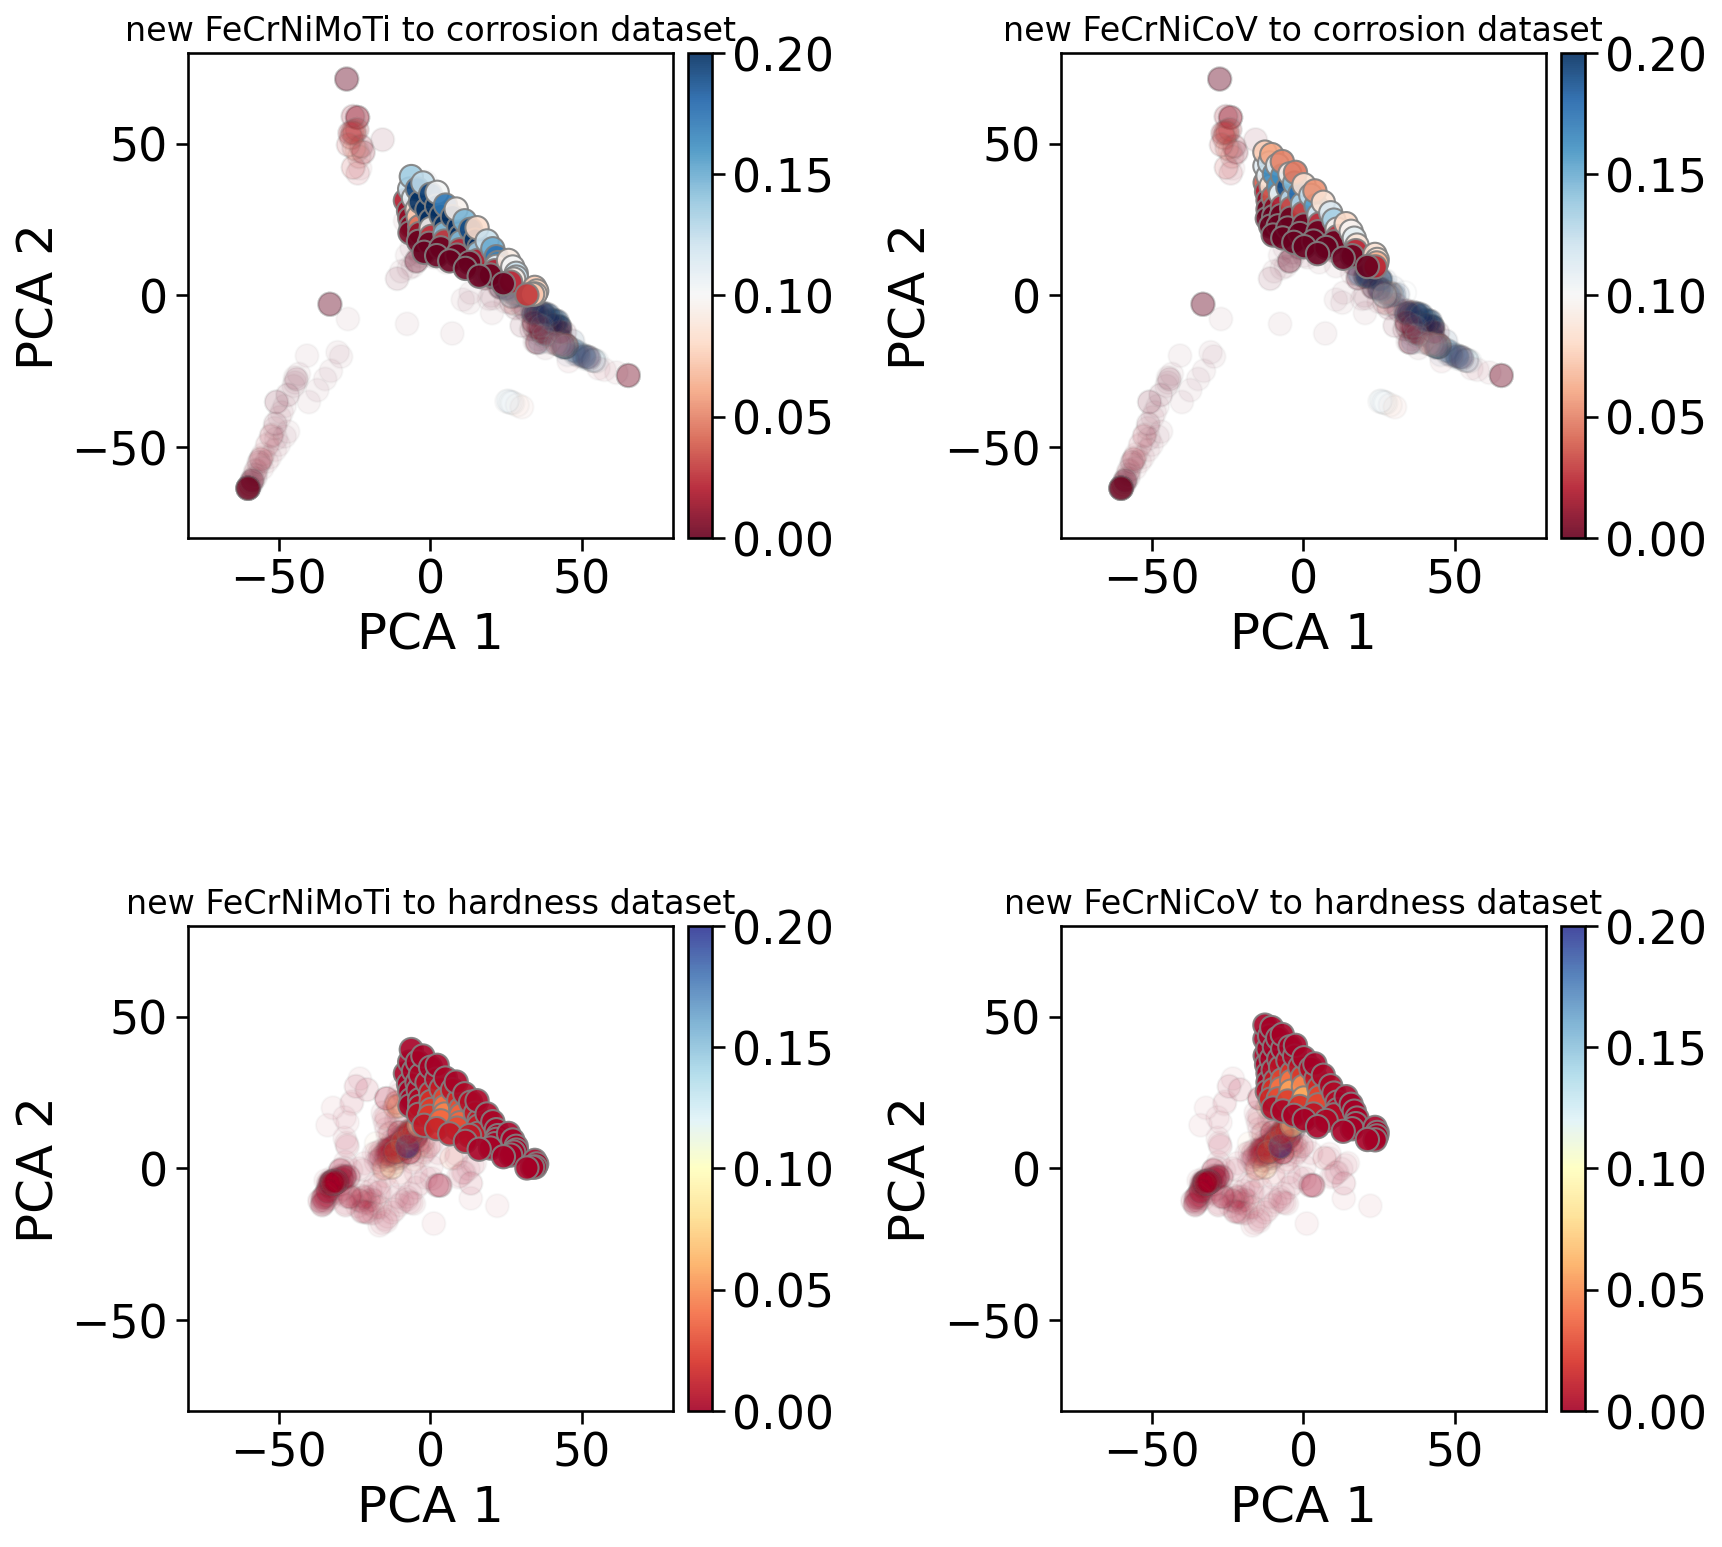

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def create_scatter(df, dataset_values, ax, cmap="RdBu", titlename = "name?"):
    # Create separate dataframes for each dataset
    df_literature = df[df["dataset"] == dataset_values[0]]
    df_new = df[df["dataset"] == dataset_values[1]]

    # Create the scatter plots
    scatters = []
    for df, alpha in zip([df_literature, df_new], [0.05, 0.9]):
        scatter = ax.scatter(df["PCA1"], df["PCA2"], c=df["p value"], cmap=cmap, edgecolor="grey", 
                             s=500, marker='.', alpha=alpha, vmin=0, vmax=0.2)
        scatters.append(scatter)

        ax.set_xlim(-80, 80)
        ax.set_ylim(-80, 80)
        ax.set_xlabel("PCA 1")
        ax.set_ylabel("PCA 2")
        # set the subplot title to the dataset name
        ax.set_title(titlename, fontsize=16)
        # make equal aspect ratio
        ax.set_aspect('equal', 'box')

    return scatters

# create the subplots of 2x2
fig, ax = plt.subplots(2, 2, figsize=(12, 12), dpi=150)

datasets = [(df_C_new_FeCrNiMoTi_Mahl_label, [0, 2], "RdBu", "new FeCrNiMoTi to corrosion dataset"),
            (df_C_new_FeCrNiCoV_Mahl_label, [0, 3], "RdBu", "new FeCrNiCoV to corrosion dataset"),
            (df_H_new_FeCrNiMoTi_Mahl_label, [1, 2], "RdYlBu", "new FeCrNiMoTi to hardness dataset"),
            (df_H_new_FeCrNiCoV_Mahl_label, [1, 3], "RdYlBu", "new FeCrNiCoV to hardness dataset")]

for i, (df, dataset_values, cmap, title) in enumerate(datasets):
    axi = ax[i//2, i%2]  # Get the current axis
    scatters = create_scatter(df, dataset_values, axi, cmap=cmap, titlename=title)

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(axi)
    # Append axes for colorbar to the right of axi, with 5% width of axi
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(scatters[-1], cax=cax)

plt.tight_layout()
plt.savefig('PCA 2D_Mahalanobis.png')
plt.show()

Now I will plot the p value on the wafer 

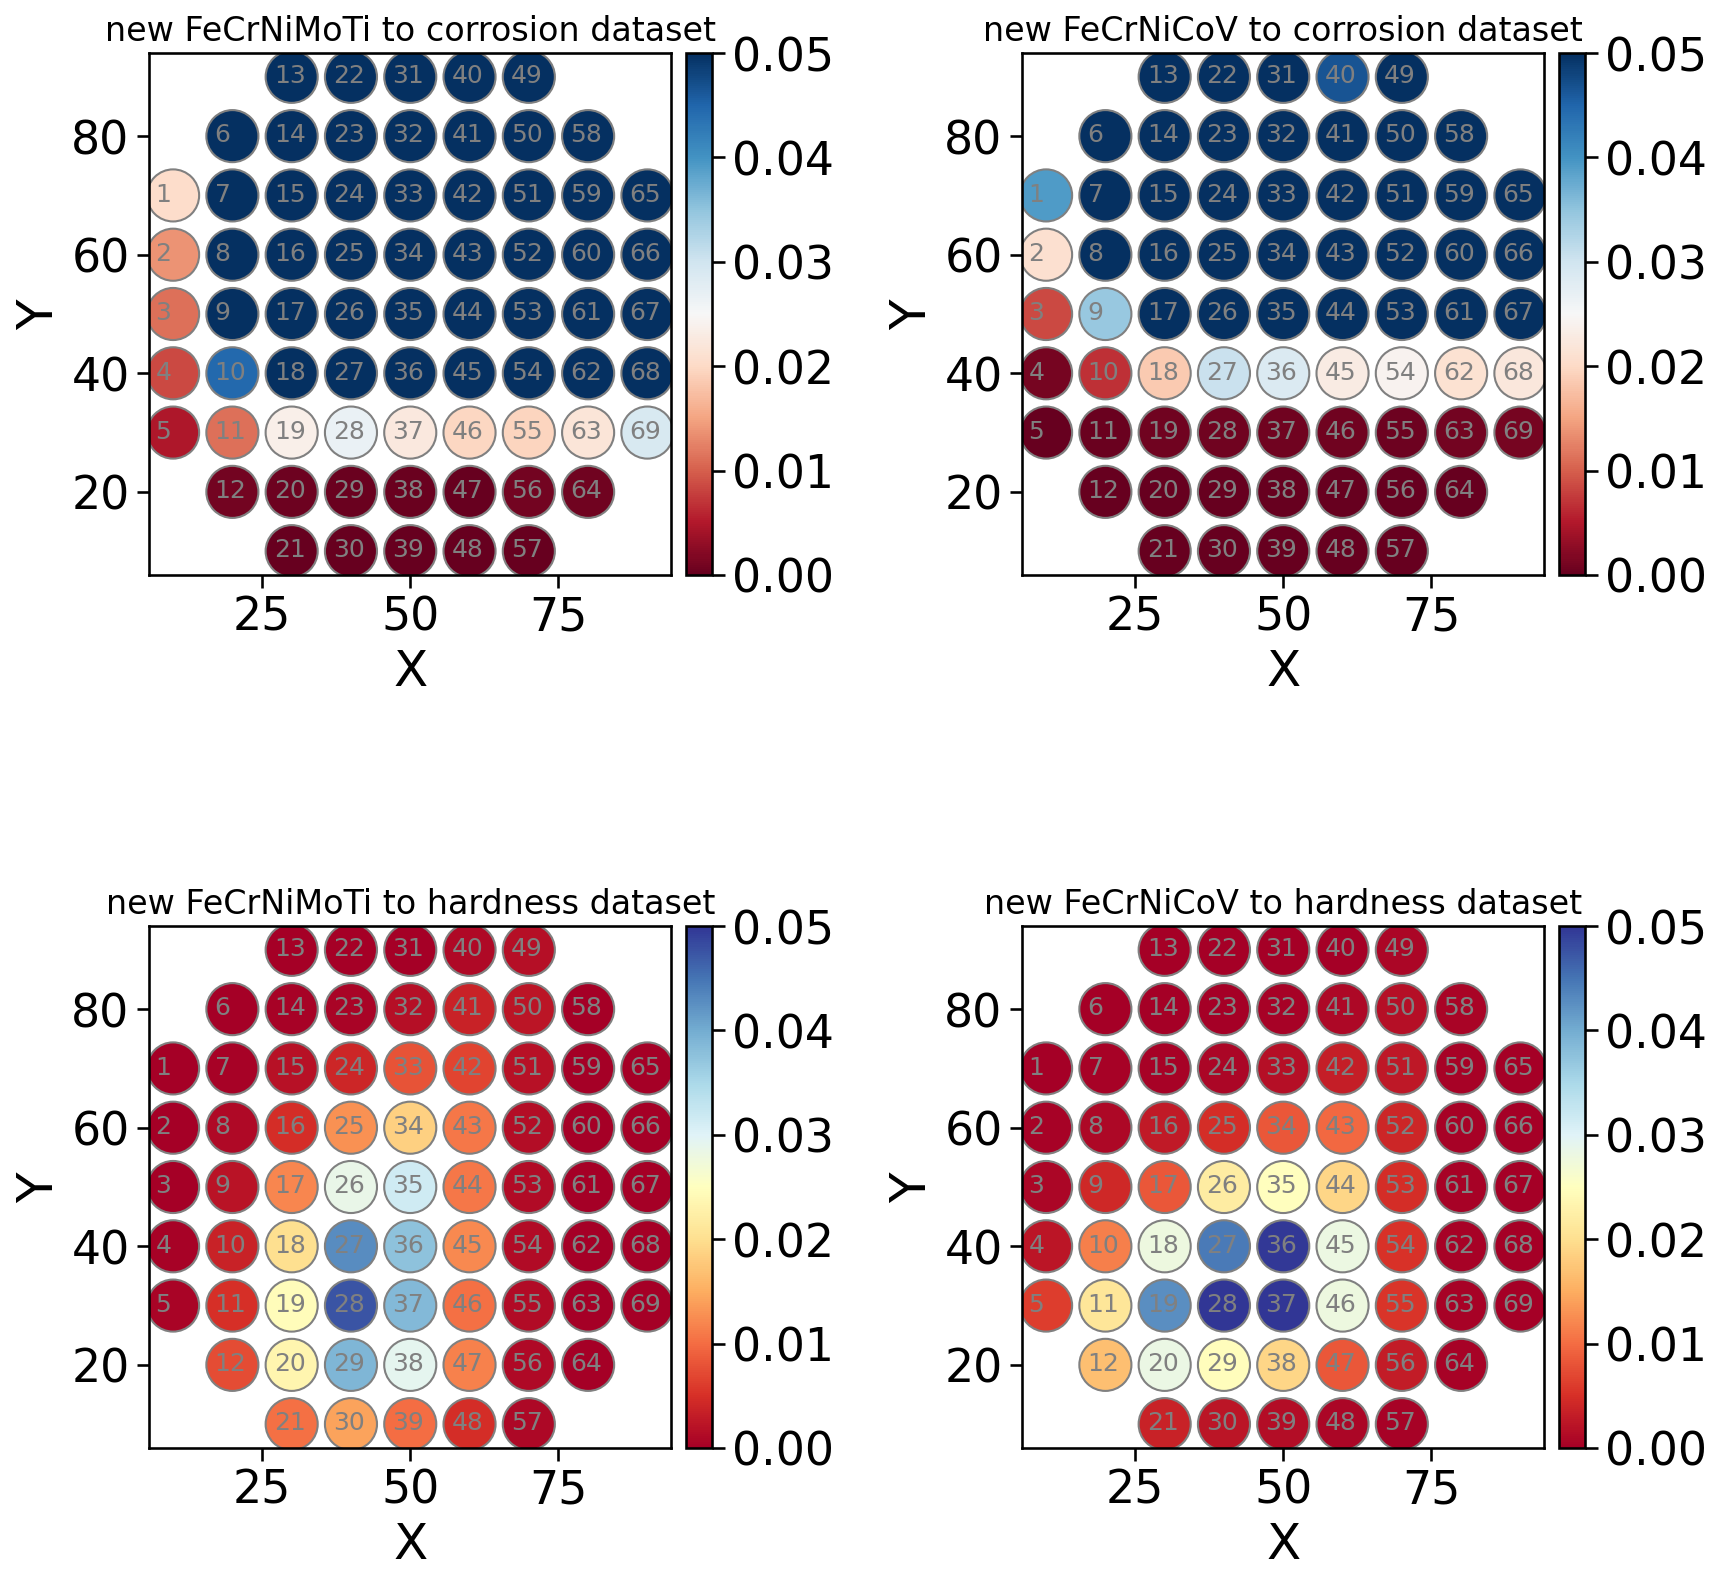

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

PVD_x_y = pd.read_excel(data_path + 'PVD_x_y.xlsx')

def create_PVD_scatter(df, PVD_x_y, dataset_values, ax, cmap="RdBu", title=""):
    # Create dataframe for the new dataset
    df_new = df[df["dataset"] == dataset_values[1]]

    # Create the scatter plot
    scatter_alpha = 1
    scatter_size = 2500
    scatter = ax.scatter(PVD_x_y["x"], PVD_x_y["y"], c=df_new["p value"], cmap=cmap, edgecolor="grey", 
                         s=scatter_size, marker='.', alpha=scatter_alpha, vmin=0, vmax=0.05)

    for i, txt in enumerate(PVD_x_y.index+1):
        ax.annotate(txt, (PVD_x_y["x"].iloc[i]-3, PVD_x_y["y"].iloc[i]-1), color="grey", alpha=1, fontsize=12)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(title, fontsize=16)
    ax.set_aspect('equal', 'box')
    
    # export the df_new to excel using the name of title
    df_new.to_excel(title + ".xlsx")
 
    return scatter

fig, ax = plt.subplots(2, 2, figsize=(12, 12), dpi=150)

datasets = [(df_C_new_FeCrNiMoTi_Mahl_label, [0, 2], "RdBu", "new FeCrNiMoTi to corrosion dataset"),
            (df_C_new_FeCrNiCoV_Mahl_label, [0, 3], "RdBu", "new FeCrNiCoV to corrosion dataset"),
            (df_H_new_FeCrNiMoTi_Mahl_label, [1, 2], "RdYlBu", "new FeCrNiMoTi to hardness dataset"),
            (df_H_new_FeCrNiCoV_Mahl_label, [1, 3], "RdYlBu", "new FeCrNiCoV to hardness dataset")]

for i, (df, dataset_values, cmap, title) in enumerate(datasets):
    axi = ax[i//2, i%2]
    scatter = create_PVD_scatter(df, PVD_x_y, dataset_values, axi, cmap=cmap, title=title)

    divider = make_axes_locatable(axi)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(scatter, cax=cax)

plt.tight_layout()
plt.savefig('PVD 2D_Mahalanobis.png')
plt.show()


other possibilities: I will also fix the level of color contours: because maybe the rational way here when selecting compositions is selecting a few ranges: close->intermediate->far from the center of the data group

In [17]:
 
z_C_new_FeCrNiMoTi_Mahl_label = df_C_new_FeCrNiMoTi_Mahl_label[df_C_new_FeCrNiMoTi_Mahl_label["dataset"] == 2]["p value"].to_numpy()

print(z_C_new_FeCrNiMoTi_Mahl_label)


[2.04106096e-02 1.38339637e-02 1.11792973e-02 8.44678808e-03
 4.77074110e-03 1.21022016e-01 1.07547908e-01 8.68446923e-02
 7.19019583e-02 4.46180908e-02 1.12286465e-02 9.35977327e-04
 1.35690339e-01 1.92700309e-01 2.48063671e-01 2.28527315e-01
 2.05097543e-01 9.51431599e-02 2.36209198e-02 5.36409858e-04
 9.18167702e-08 1.25675900e-01 1.94689420e-01 2.79591999e-01
 3.28760459e-01 3.03744823e-01 1.40436713e-01 2.66149089e-02
 3.24238165e-04 5.23261123e-09 1.01694120e-01 1.72152853e-01
 2.54105421e-01 2.97216032e-01 2.74531258e-01 1.41682817e-01
 2.22975156e-02 2.64793349e-04 1.20801935e-09 9.54923818e-02
 1.45524280e-01 1.92181203e-01 2.53278478e-01 2.47084112e-01
 1.32416010e-01 1.95670692e-02 1.49084523e-04 2.12827089e-08
 8.20456777e-02 1.22602425e-01 1.49621576e-01 1.74951729e-01
 1.66025971e-01 1.05149906e-01 1.94330034e-02 8.45994977e-04
 1.45069805e-08 9.19429617e-02 1.01266623e-01 1.22526280e-01
 1.21780626e-01 9.26428833e-02 2.18395906e-02 6.67596908e-04
 7.44865823e-02 7.914263

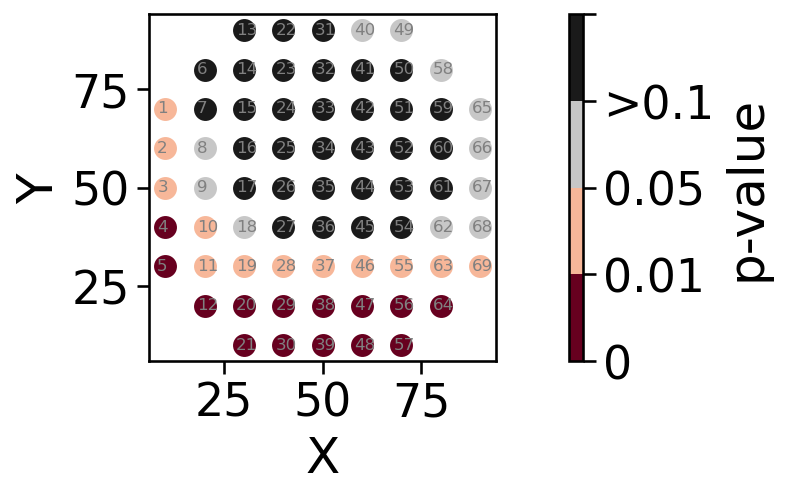

In [18]:

fig, (ax1, ax2) = plt.subplots(figsize = (4, 3),
                          ncols = 2, gridspec_kw={'width_ratios': [3, 0.1]}, dpi=150)

# plot the fixed intervals 
cmap = cm.RdGy(np.linspace(0, 1, 4))  # RdBu/RdGy
 
c_0_01     = [i for i,v in enumerate(z_C_new_FeCrNiMoTi_Mahl_label) if v < 0.01]
c_0_05    = [i for i,v in enumerate(z_C_new_FeCrNiMoTi_Mahl_label) if v < 0.05 and v >= 0.01]
c_0_1     = [i for i,v in enumerate(z_C_new_FeCrNiMoTi_Mahl_label) if v < 0.1  and v >= 0.05]
c_abv_0_1 = [i for i,v in enumerate(z_C_new_FeCrNiMoTi_Mahl_label) if              v >= 0.1]

cax1 = ax1.scatter(PVD_x_y["x"][c_0_01],    PVD_x_y["y"][c_0_01],    color=cmap[0], s=400, marker='.') # ,vmin=0.2, vmax=0.6
cax2 = ax1.scatter(PVD_x_y["x"][c_0_05],    PVD_x_y["y"][c_0_05],    color=cmap[1], s=400, marker='.') # ,vmin=0.2, vmax=0.6
cax3 = ax1.scatter(PVD_x_y["x"][c_0_1],     PVD_x_y["y"][c_0_1],     color=cmap[2], s=400, marker='.') # ,vmin=0.2, vmax=0.6
cax4 = ax1.scatter(PVD_x_y["x"][c_abv_0_1], PVD_x_y["y"][c_abv_0_1], color=cmap[3], s=400, marker='.') # ,vmin=0.2, vmax=0.6

ax1.set_aspect('equal', 'box')
for i, txt in enumerate(PVD_x_y.index+1):
    ax1.annotate(txt, (PVD_x_y["x"][i]-2, PVD_x_y["y"][i]-1), color="grey", alpha=1, fontsize=8)
 
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
# ax1.set_title(KW_name+'_'+PT_name) 


# customised colorbar: https://matplotlib.org/stable/tutorials/colors/colorbar_only.html

cmap = mpl.cm.RdGy  #RdBu/RdGy
bounds = [0, 1, 2, 3, 4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax2, orientation='vertical',  
             label="p-value")
cbar.ax.set_yticklabels(['0','0.01','0.05','>0.1',''])

plt.show()